<a href="https://colab.research.google.com/github/bkkaggle/pytorch-CycleGAN-and-pix2pix/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/CycleGAN/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Import necessary libraries
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random, os, numpy as np
import torch.nn as nn
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
# Set device to GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Hyperparameters
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 2
NUM_EPOCHS = 10
LOAD_MODEL = False
SAVE_MODEL = True
# Trained model file names
TRAINED_MODEL_GEN_H = "genh.pth.tar"
TRAINED_MODEL_GEN_Z = "genz.pth.tar"
TRAINED_MODEL_CRITIC_H = "critich.pth.tar"
TRAINED_MODEL_CRITIC_Z = "criticz.pth.tar"
# Define image transformations
transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-07 11:55:08--  https://www.robots.ox.ac.uk/~vgg/data/celeba/files/CelebA_Img.zip
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-05-07 11:55:09 ERROR 404: Not Found.

--2023-05-07 11:55:10--  https://raw.githubusercontent.com/DobriyMikhail/celeba-attribution-prediction/master/list_attr_celeba.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-05-07 11:55:10 ERROR 404: Not Found.

--2023-05-07 11:55:10--  https://download.pytorch.org/models/resnet34-333f7ec4.pth
Resolving download.pyto

KeyboardInterrupt: ignored

In [ ]:
# Function to save trained model
def save_trained_model(model, optimizer, filename="my_trained_model.pth.tar"):
    print("=> Saving trained_model")
    trained_model = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(trained_model, filename)

# Function to load trained model
def load_trained_model(trained_model_file, model, optimizer, lr):
    print("=> Loading trained_model")
    trained_model = torch.load(trained_model_file, map_location=DEVICE)
    model.load_state_dict(trained_model["state_dict"])
    optimizer.load_state_dict(trained_model["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# Function to seed all random number generators for reproducibility
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# FacadesDataset is a custom dataset class that loads and processes images from two directories (shapes, real)
class FacadesDataset(Dataset):
    def __init__(self, root_shapes, root_real, transform=None):
        self.root_shapes = root_shapes
        self.root_real = root_real
        self.transform = transform

        self.shapes_images = os.listdir(root_shapes)
        self.real_images = os.listdir(root_real)
        # Print the paths of the input directories
        print(f"Shapes folder path: {root_shapes}")
        print(f"Real folder path: {root_real}")
        # Check if both directories have images
        if not self.shapes_images or not self.real_images:
            raise ValueError("One or both image directories are empty. Make sure there are images in both directories.")
        # Set the length of the dataset to the maximum length of the two directories
        self.length_dataset = max(len(self.shapes_images), len(self.real_images)) # 1000, 1500
        self.shapes_len = len(self.shapes_images)
        self.real_len = len(self.real_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        # Load the images corresponding to the given index, using modulo to loop through the directories
        shapes_img = self.shapes_images[index % self.shapes_len]
        real_img = self.real_images[index % self.real_len]

        shapes_path = os.path.join(self.root_shapes, shapes_img)
        real_path = os.path.join(self.root_real, real_img)
        # Open and convert the images to RGB format
        shapes_img = np.array(Image.open(shapes_path).convert("RGB"))
        real_img = np.array(Image.open(real_path).convert("RGB"))
        # Apply the given transform to the images
        if self.transform:
            augmentations = self.transform(image=shapes_img, image0=real_img)
            shapes_img = augmentations["image"]
            real_img = augmentations["image0"]

        return shapes_img, real_img

In [ ]:

# ConvBlock is a custom convolutional block that can be used for both downsampling and upsampling
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

# ResidualBlock is a custom residual block containing two convolutional layers
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

# Generator is the main generator model, containing the initial layer, down blocks, residual blocks, up blocks, and the last layer
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


In [ ]:
# Define the Block class, which is a building block for the Discriminator
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        # Create a sequence of convolutional layers, instance normalization, and leaky ReLU activation
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                4,
                stride,
                1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        # Apply the convolutional block to the input tensor
        return self.conv(x)

# Define the Discriminator class, which is a neural network used for image classification
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # Create the initial convolutional layer and leaky ReLU activation
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Create a list to store the layers of the model
        layers = []
        in_channels = features[0]
        # Iterate through the features and create a Block for each pair of input and output channels
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        # Add the final convolutional layer to output a single channel
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        # Combine the layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input tensor through the initial layer and the main model
        x = self.initial(x)
        # Apply the sigmoid activation function to the output of the model
        return torch.sigmoid(self.model(x))


In [ ]:
# Define the training function for the cycle GAN model
def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    # Initialize counters for real and fake images
    H_reals = 0
    H_fakes = 0
    # Create a progress bar for the data loader
    loop = tqdm(loader, leave=True)
    # Iterate over the data loader  
    for idx, (shapes, real) in enumerate(loop):
        shapes = shapes.to(DEVICE)
        real = real.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            # Generate fake images from real images
            fake_real = gen_H(shapes)
            # Calculate discriminator H's real and fake losses
            D_H_real = disc_H(real)
            D_H_fake = disc_H(fake_real.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss
            # Generate fake shapes from real images
            fake_shapes = gen_Z(real)
            # Calculate discriminator Z's real and fake losses
            D_Z_real = disc_Z(shapes)
            D_Z_fake = disc_Z(fake_shapes.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # Combine the losses of the two discriminators
            D_loss = (D_H_loss + D_Z_loss) / 2
        # Update the discriminator's gradients and parameters
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # Calculate generator H's loss
            D_H_fake = disc_H(fake_real)
            D_Z_fake = disc_Z(fake_shapes)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))
            # Calculate cycle consistency losses
            cycle_shapes = gen_Z(fake_real)
            cycle_real = gen_H(fake_shapes)
            cycle_shapes_loss = l1(shapes, cycle_shapes)
            cycle_real_loss = l1(real, cycle_real)
            # Calculate identity losses
            identity_shapes = gen_Z(shapes)
            identity_real = gen_H(real)
            identity_shapes_loss = l1(shapes, identity_shapes)
            identity_real_loss = l1(real, identity_real)
            # Combine all generator losses
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_shapes_loss * LAMBDA_CYCLE
                + cycle_real_loss * LAMBDA_CYCLE
                + identity_real_loss * LAMBDA_IDENTITY
                + identity_shapes_loss * LAMBDA_IDENTITY
            )
        # Update the generator's gradients and parameters
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        # Save generated images every 20 iterations
        if idx % 20 == 0:
            save_image(fake_real * 0.5 + 0.5, f"saved_results/real_to_shapes_{idx}.png")
            save_image(fake_shapes * 0.5 + 0.5, f"saved_results/shapes_to_real_{idx}.png")
        # Update the progress bar with the current losses
        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))

# Define the train function to initialize and train the GAN
def train():
    # Initialize the discriminators for real images and shapes with input channels set to 3 (RGB)
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    # Initialize the generators for real images and shapes with input channels set to 3 (RGB) and 9 residual blocks
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    # Set up the optimizers for the discriminators using the Adam optimizer
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )
    # Set up the optimizers for the generators using the Adam optimizer
    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )
    # Set up the L1 loss and Mean Squared Error loss functions    
    L1 = nn.L1Loss()
    mse = nn.MSELoss()
    # Load pre-trained models if the LOAD_MODEL flag is set to True 
    if LOAD_MODEL:
        load_trained_model(
            TRAINED_MODEL_GEN_H,
            gen_H,
            opt_gen,
            LEARNING_RATE,
        )
        load_trained_model(
            TRAINED_MODEL_GEN_Z,
            gen_Z,
            opt_gen,
            LEARNING_RATE,
        )
        load_trained_model(
            TRAINED_MODEL_CRITIC_H,
            disc_H,
            opt_disc,
            LEARNING_RATE,
        )
        load_trained_model(
            TRAINED_MODEL_CRITIC_Z,
            disc_Z,
            opt_disc,
            LEARNING_RATE,
        )
    # Set up the training and validation datasets   
    dataset = FacadesDataset(
        root_real="data/facades/train_real",
        root_shapes="data/facades/train_shapes",
        transform=transforms,
    )
    val_dataset = FacadesDataset(
        root_real="data/facades/test_real",
        root_shapes="data/facades/test_shapes",
        transform=transforms,
    )
    # Set up the DataLoader for the validation dataset
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    # Set up the DataLoader for the training dataset
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    # Set up gradient scaling for mixed precision training
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    # Train the GAN for the specified number of epochs
    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )
        # Save the trained models if the SAVE_MODEL flag is set to True
        if SAVE_MODEL:
            save_trained_model(gen_H, opt_gen, filename=TRAINED_MODEL_GEN_H)
            save_trained_model(gen_Z, opt_gen, filename=TRAINED_MODEL_GEN_Z)
            save_trained_model(disc_H, opt_disc, filename=TRAINED_MODEL_CRITIC_H)
            save_trained_model(disc_Z, opt_disc, filename=TRAINED_MODEL_CRITIC_Z)







    


In [ ]:
train()

Shapes folder path: data/facades/train_shapes
Real folder path: data/facades/train_real
Shapes folder path: data/facades/test_shapes
Real folder path: data/facades/test_real


100%|██████████| 400/400 [01:41<00:00,  3.93it/s, H_fake=0.427, H_real=0.572]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:42<00:00,  3.91it/s, H_fake=0.397, H_real=0.595]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:41<00:00,  3.93it/s, H_fake=0.415, H_real=0.576]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:42<00:00,  3.91it/s, H_fake=0.411, H_real=0.581]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:41<00:00,  3.92it/s, H_fake=0.406, H_real=0.585]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:41<00:00,  3.94it/s, H_fake=0.41, H_real=0.586]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:41<00:00,  3.92it/s, H_fake=0.409, H_real=0.58]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:42<00:00,  3.92it/s, H_fake=0.41, H_real=0.586]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:42<00:00,  3.92it/s, H_fake=0.404, H_real=0.589]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


100%|██████████| 400/400 [01:42<00:00,  3.92it/s, H_fake=0.402, H_real=0.592]


=> Saving trained_model
=> Saving trained_model
=> Saving trained_model
=> Saving trained_model


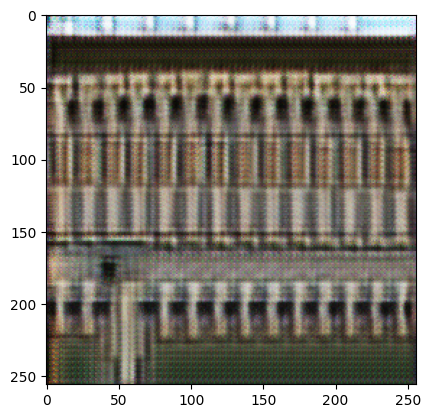

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./saved_results/real_to_shapes_380.png')
plt.imshow(img)

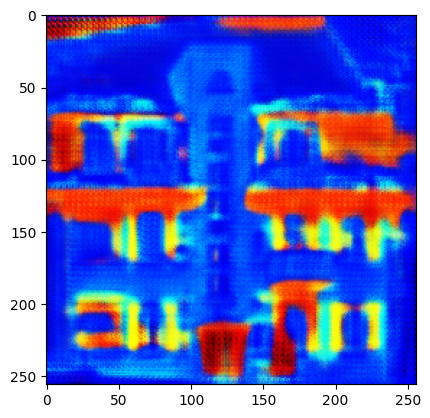

In [ ]:
img = plt.imread('./saved_results/shapes_to_real_380.png')
plt.imshow(img)